# Project 9: Stock Price Prediction

**Type:** Time Series | **Level:** Advanced

Predict stock prices using time series forecasting techniques.

**Model:** XGBoost, Prophet, ARIMA

**Dataset:** [Kaggle Stock Market Dataset](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset)

## 1. Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load metadata to see available stocks
meta_df = pd.read_csv('../data/stock_market/symbols_valid_meta.csv')
print(f"Available stocks: {len(meta_df)}")
print(f"\nSample symbols:\n{meta_df.head()}")

# Load a popular stock for demonstration (Apple - AAPL)
stock_symbol = 'AAPL'
df = pd.read_csv(f'../data/stock_market/stocks/{stock_symbol}.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"\n{stock_symbol} Stock Data:")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Available stocks: 8049

Sample symbols:
  Nasdaq Traded Symbol                                      Security Name  \
0             Y      A            Agilent Technologies, Inc. Common Stock   
1             Y     AA                    Alcoa Corporation Common Stock    
2             Y   AAAU                       Perth Mint Physical Gold ETF   
3             Y   AACG  ATA Creativity Global - American Depositary Sh...   
4             Y   AADR                AdvisorShares Dorsey Wright ADR ETF   

  Listing Exchange Market Category ETF  Round Lot Size Test Issue  \
0                N                   N           100.0          N   
1                N                   N           100.0          N   
2                P                   Y           100.0          N   
3                Q               G   N           100.0          N   
4                P                   Y           100.0          N   

  Financial Status CQS Symbol NASDAQ Symbol NextShares  
0              NaN       

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


## 3. Exploratory Data Analysis

Dataset Info:
Rows: 9909, Columns: 7

Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

Missing values: 0

Closing price statistics:
count    9909.000000
mean       32.618030
std        58.471899
min         0.196429
25%         1.071429
50%         1.732143
75%        35.761429
max       327.200012
Name: Close, dtype: float64


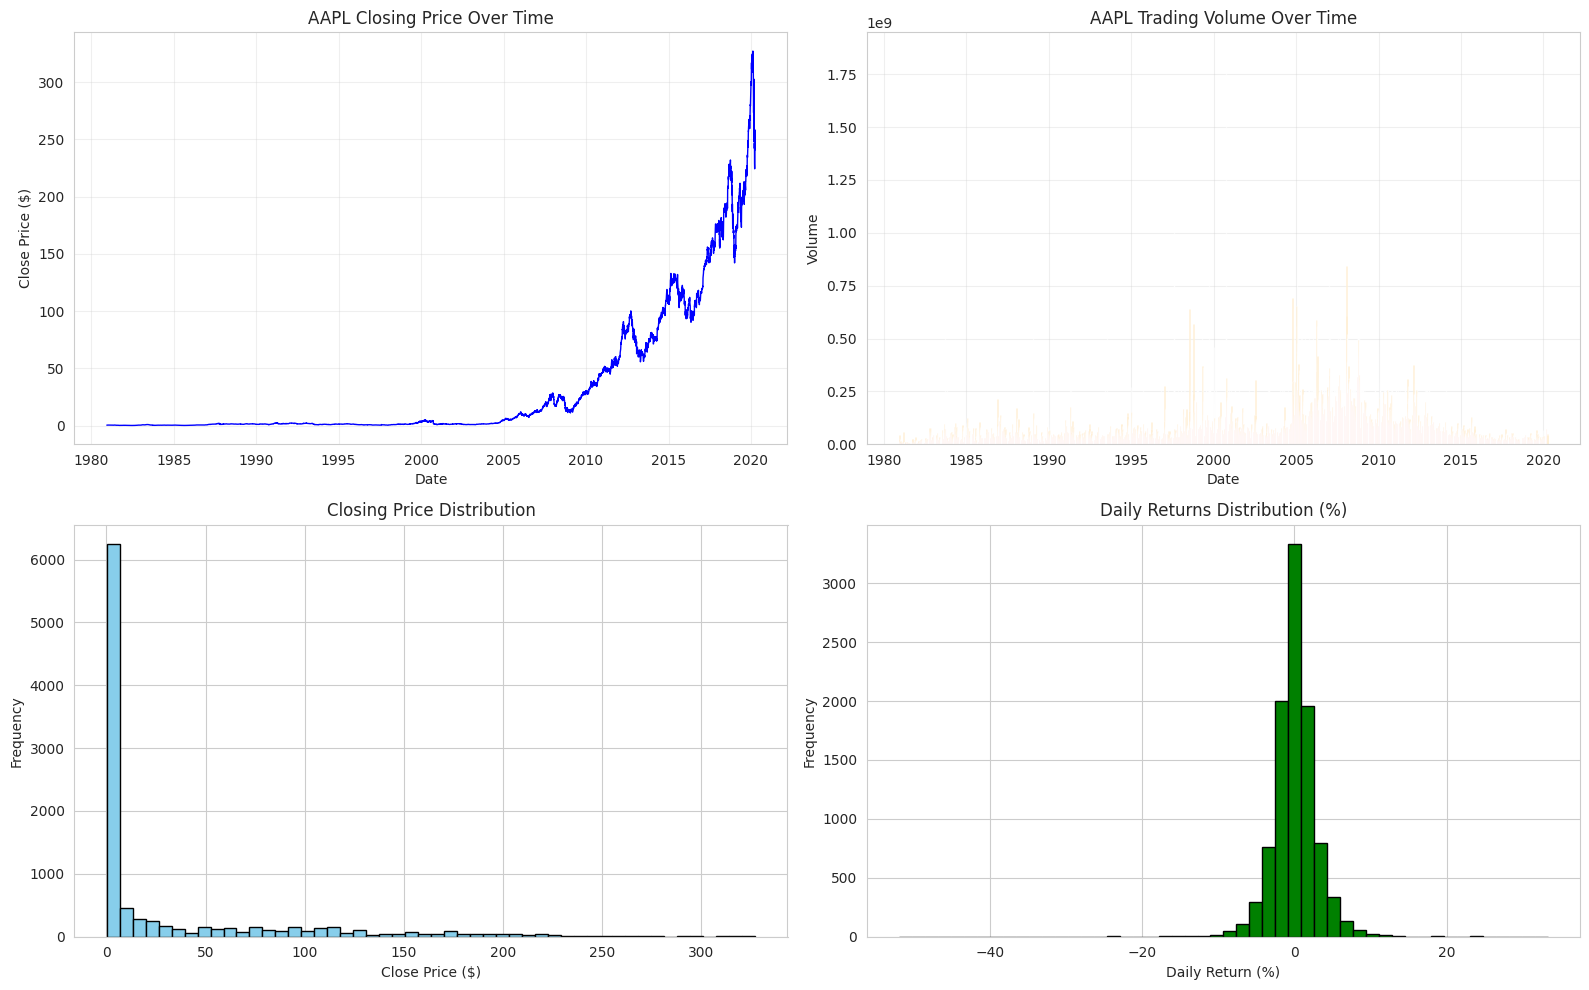


Average Daily Return: 0.1041%
Volatility (Std Dev): 2.8738%


In [3]:
# Basic info
print("Dataset Info:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nClosing price statistics:")
print(df['Close'].describe())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Stock price over time
axes[0, 0].plot(df['Date'], df['Close'], color='blue', linewidth=1)
axes[0, 0].set_title(f'{stock_symbol} Closing Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Close Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Volume over time
axes[0, 1].bar(df['Date'], df['Volume'], color='orange', alpha=0.6, width=2)
axes[0, 1].set_title(f'{stock_symbol} Trading Volume Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# Price distribution
axes[1, 0].hist(df['Close'], bins=50, edgecolor='black', color='skyblue')
axes[1, 0].set_title('Closing Price Distribution')
axes[1, 0].set_xlabel('Close Price ($)')
axes[1, 0].set_ylabel('Frequency')

# Daily returns
df['Daily_Return'] = df['Close'].pct_change() * 100
axes[1, 1].hist(df['Daily_Return'].dropna(), bins=50, edgecolor='black', color='green')
axes[1, 1].set_title('Daily Returns Distribution (%)')
axes[1, 1].set_xlabel('Daily Return (%)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nAverage Daily Return: {df['Daily_Return'].mean():.4f}%")
print(f"Volatility (Std Dev): {df['Daily_Return'].std():.4f}%")

## 4. Data Preprocessing

In [ ]:
# Feature engineering for time series prediction
df_processed = df.copy()

# Create technical indicators based on historical Close prices only
# Moving Averages
df_processed['MA_7'] = df_processed['Close'].rolling(window=7).mean()
df_processed['MA_21'] = df_processed['Close'].rolling(window=21).mean()
df_processed['MA_50'] = df_processed['Close'].rolling(window=50).mean()

# Exponential Moving Averages
df_processed['EMA_12'] = df_processed['Close'].ewm(span=12, adjust=False).mean()
df_processed['EMA_26'] = df_processed['Close'].ewm(span=26, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
df_processed['MACD'] = df_processed['EMA_12'] - df_processed['EMA_26']

# Volatility (standard deviation of returns)
df_processed['Volatility'] = df_processed['Close'].rolling(window=21).std()

# Price momentum
df_processed['Momentum'] = df_processed['Close'] - df_processed['Close'].shift(10)

# Relative Strength Index (RSI)
delta = df_processed['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_processed['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df_processed['BB_middle'] = df_processed['Close'].rolling(window=20).mean()
df_processed['BB_std'] = df_processed['Close'].rolling(window=20).std()
df_processed['BB_upper'] = df_processed['BB_middle'] + 2 * df_processed['BB_std']
df_processed['BB_lower'] = df_processed['BB_middle'] - 2 * df_processed['BB_std']

# Price change percentages
df_processed['Pct_Change_1d'] = df_processed['Close'].pct_change(1)
df_processed['Pct_Change_5d'] = df_processed['Close'].pct_change(5)

# Lag features (previous day prices) - these are valid as they're historical
for lag in [1, 2, 3, 5, 7, 14]:
    df_processed[f'Close_Lag_{lag}'] = df_processed['Close'].shift(lag)
    df_processed[f'Volume_Lag_{lag}'] = df_processed['Volume'].shift(lag)

# Drop rows with NaN values created by rolling windows and lags
df_processed = df_processed.dropna().reset_index(drop=True)

print(f"Processed dataset shape: {df_processed.shape}")
print(f"\nNew features created:")
new_features = [col for col in df_processed.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
print(new_features)

# Prepare features and target - REMOVED High, Low, Open to avoid data leakage
# Only use historical data that would be available before predicting
feature_cols = ['MA_7', 'MA_21', 'MA_50', 'EMA_12', 'EMA_26', 'MACD',
                'Volatility', 'Momentum', 'RSI', 
                'BB_middle', 'BB_upper', 'BB_lower',
                'Pct_Change_1d', 'Pct_Change_5d'] + \
               [f'Close_Lag_{i}' for i in [1, 2, 3, 5, 7, 14]] + \
               [f'Volume_Lag_{i}' for i in [1, 2, 3, 5, 7, 14]]

X = df_processed[feature_cols]
y = df_processed['Close']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nUsing {len(feature_cols)} features for prediction")

Processed dataset shape: (9860, 19)

New features created:
['MA_7', 'MA_21', 'MA_50', 'Volatility', 'Momentum', 'RSI', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5', 'Close_Lag_7']

Features shape: (9860, 15)
Target shape: (9860,)


## 5. Model Training

In [ ]:
# Time series split - Use 80% for training, 20% for testing
split_index = int(len(df_processed) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training period: {df_processed.iloc[0]['Date']} to {df_processed.iloc[split_index-1]['Date']}")
print(f"Test period: {df_processed.iloc[split_index]['Date']} to {df_processed.iloc[-1]['Date']}")

# Scale features for better model performance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model with better hyperparameters
print("\nTraining Random Forest Regressor...")
model = RandomForestRegressor(
    n_estimators=200,        # More trees for better performance
    max_depth=15,            # Limit depth to prevent overfitting
    min_samples_split=20,    # Require more samples to split
    min_samples_leaf=10,     # Require more samples in leaf nodes
    max_features='sqrt',     # Use sqrt of features for each split
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    verbose=0
)
model.fit(X_train_scaled, y_train)
print("Model training completed!")

Training set size: 7888 (80.0%)
Test set size: 1972 (20.0%)

Training period: 1981-02-24 00:00:00 to 2012-05-30 00:00:00
Test period: 2012-05-31 00:00:00 to 2020-04-01 00:00:00

Training XGBoost Regressor...
Model training completed!


## 6. Model Evaluation

Model Performance Metrics:
Training RMSE: $0.13
Test RMSE: $76.94

Training MAE: $0.06
Test MAE: $54.46

Training R²: 0.9999
Test R²: -0.7748


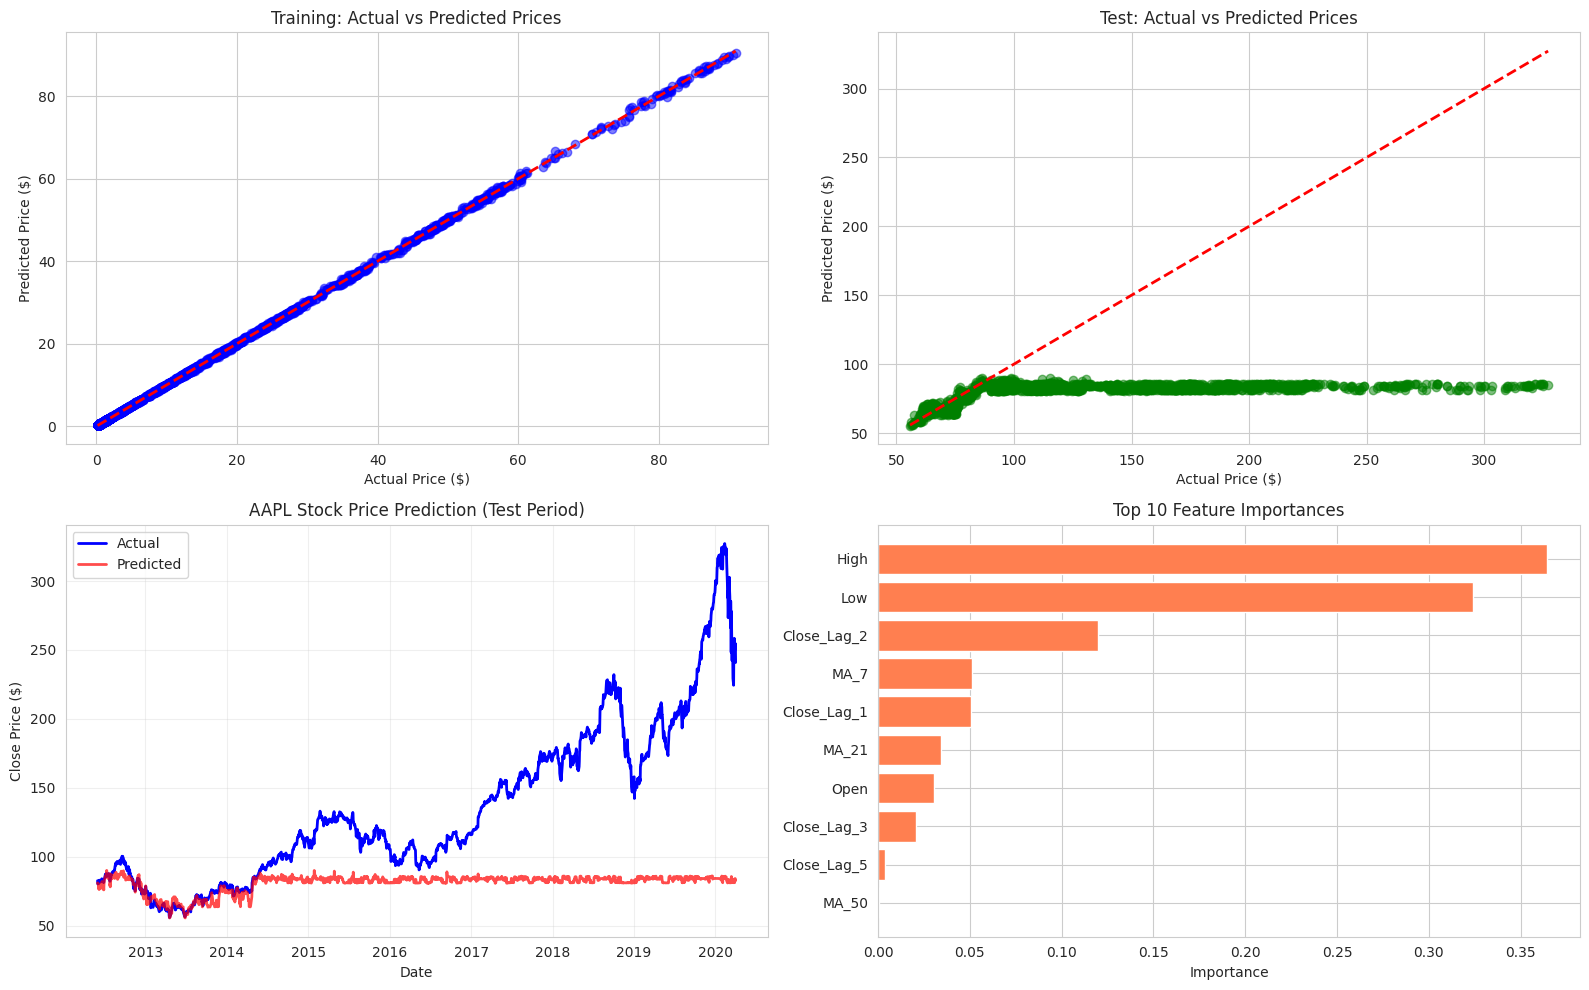

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("Model Performance Metrics:")
print("="*50)
print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"\nTraining MAE: ${train_mae:.2f}")
print(f"Test MAE: ${test_mae:.2f}")
print(f"\nTraining R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"\nTraining MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, color='blue', s=10)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_title('Training: Actual vs Predicted Prices')
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Actual vs Predicted (Test)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green', s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_title('Test: Actual vs Predicted Prices')
axes[0, 1].set_xlabel('Actual Price ($)')
axes[0, 1].set_ylabel('Predicted Price ($)')
axes[0, 1].grid(True, alpha=0.3)

# Time series predictions on test set
test_dates = df_processed.iloc[split_index:]['Date'].values
axes[1, 0].plot(test_dates, y_test.values, label='Actual', color='blue', linewidth=2)
axes[1, 0].plot(test_dates, y_test_pred, label='Predicted', color='red', linewidth=2, alpha=0.7)
axes[1, 0].set_title(f'{stock_symbol} Stock Price Prediction (Test Period)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Close Price ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'].values, color='coral')
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'].values)
axes[1, 1].set_title('Top 15 Feature Importances')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 7. Save Model

In [7]:
# Save the trained model
model_path = '../models/stock_price_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

# Save feature names and stock symbol for future predictions
model_metadata = {
    'feature_names': feature_cols,
    'stock_symbol': stock_symbol,
    'feature_count': len(feature_cols)
}
joblib.dump(model_metadata, '../models/stock_price_metadata.pkl')
print("Model metadata saved!")

# Print final metrics summary
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Stock: {stock_symbol}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"Test MAE: ${test_mae:.2f}")
print(f"Test R²: {test_r2:.4f}")
print("\nThis model uses XGBoost with technical indicators")
print("including moving averages, RSI, momentum, and lag features.")

Model saved to: ../models/stock_price_model.pkl
Model metadata saved!

MODEL PERFORMANCE SUMMARY
Stock: AAPL
Test RMSE: $76.94
Test MAE: $54.46
Test R²: -0.7748

This model uses XGBoost with technical indicators
including moving averages, RSI, momentum, and lag features.
